In [1]:
import scanpy as sc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as adt
from scipy.sparse import csr_matrix
import umap
import scanpy.external as sce

In [2]:
import warnings 
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Concatenation & UMAP

In [3]:
adatas_red = []
data_dir = 'C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/Formated_data'

for filename in os.listdir(data_dir):
    if filename.endswith('.h5ad'):
            adata = sc.read_h5ad(os.path.join(data_dir, filename))
            adata.var_names_make_unique()
            adatas_red.append(adata)

print(f"Nombre de fichiers h5ad chargés avec succès : {len(adatas_red)}")

Nombre de fichiers h5ad chargés avec succès : 6


In [4]:
sum(adatas_red[3].var['Genes'] == 'FOXJ1')

1

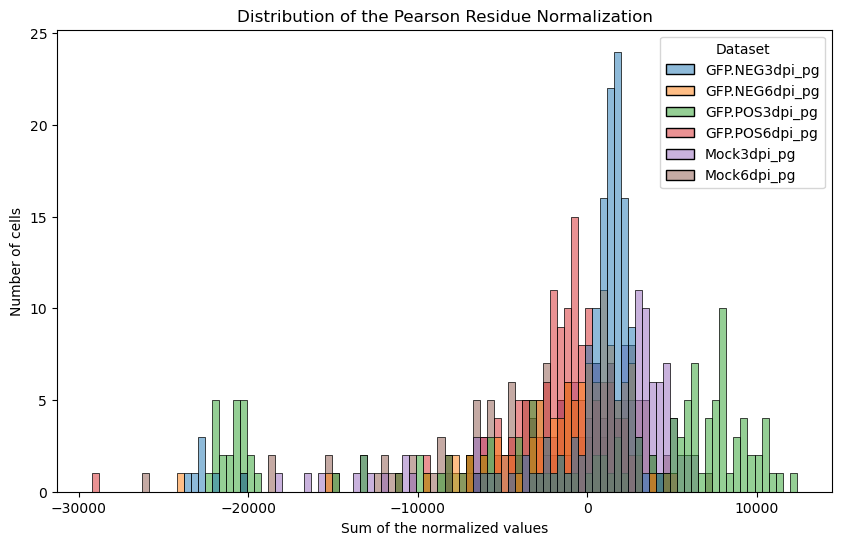

In [5]:
plot_data = []

for ade in adatas_red:
    ad = ade.copy()
    ad.X = np.nan_to_num(ad.X, nan=0.0)
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    
    X_fixed = analytic_pearson["X"]
    
    plot_data.extend([(x, ad.obs['Id'][0]) for x in csr_matrix(X_fixed).sum(1).A1])

df_plot = pd.DataFrame(plot_data, columns=["Normalized Sum", "Dataset"])

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_plot, x="Normalized Sum", hue="Dataset", bins=100, kde=False, palette="tab10")

plt.xlabel("Sum of the normalized values")
plt.ylabel("Number of cells")
plt.title("Distribution of the Pearson Residue Normalization")

# Afficher le plot
plt.show()

In [6]:
adata1 = adt.concat(adatas_red, join="outer", index_unique="-", merge="unique")
adata1.layers['raw'] = adata1.X
adata1.X = np.nan_to_num(adata1.X, nan=0.0)

In [7]:
adata1.var['Genes'] = 'Unknown'
for ade in adatas_red:
    gene_mapping = ade.var["Genes"].to_dict()
    for prot in adata1.var.index:
        if adata1.var.at[prot, "Genes"] == "Unknown" and prot in gene_mapping:
            adata1.var.at[prot, "Genes"] = gene_mapping[prot]

In [8]:
adata1.var

,Genes
1433B_HUMAN,YWHAB
1433E_HUMAN,YWHAE
1433F_HUMAN,YWHAH
1433G_HUMAN,YWHAG
1433S_HUMAN,SFN
...,...
ZO2_HUMAN,TJP2
ZO3_HUMAN,TJP3
ZRAB2_HUMAN,ZRANB2
ZSWM8_HUMAN,ZSWIM8


In [9]:
sum(adata1.var['Genes'] == 'FOXJ1')

1

In [10]:
adata1.obs["sample"] = ["Mock" if "Mock" in str(x) else "Inf" for x in adata1.obs["Id"]]
adata_mock = adata1[adata1.obs["sample"] == "Mock"]

In [11]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata_mock, inplace=False)
X_fixed = analytic_pearson["X"]
X_fixed[np.isnan(X_fixed)] = 0 
adata_mock.layers["analytic_pearson_residuals_train"] = csr_matrix(X_fixed)
adata_mock.X = adata_mock.layers["analytic_pearson_residuals_train"]
sc.pp.pca(adata_mock)
sce.pp.scanorama_integrate(adata_mock, 'Id', verbose =1)

Processing datasets Mock3dpi_pg <=> Mock6dpi_pg


  File "C:\Users\MDV\anaconda3\envs\annot\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\MDV\anaconda3\envs\annot\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MDV\anaconda3\envs\annot\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MDV\

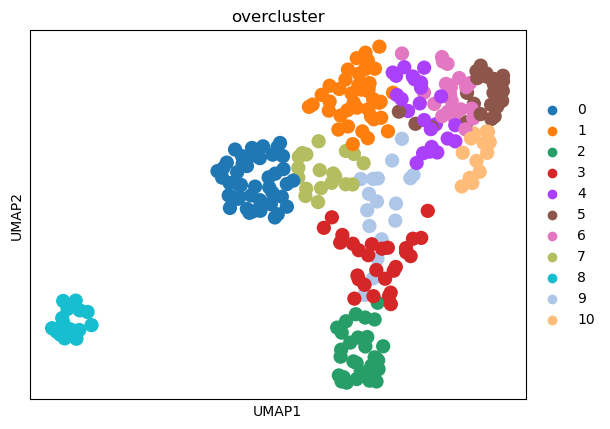

In [12]:
sc.pp.neighbors(adata_mock, use_rep = 'X_scanorama')
sc.tl.leiden(adata_mock, resolution = 2, key_added = 'overcluster')
sc.tl.umap(adata_mock)
sc.pl.umap(
    adata_mock,
    color=['overcluster']
)

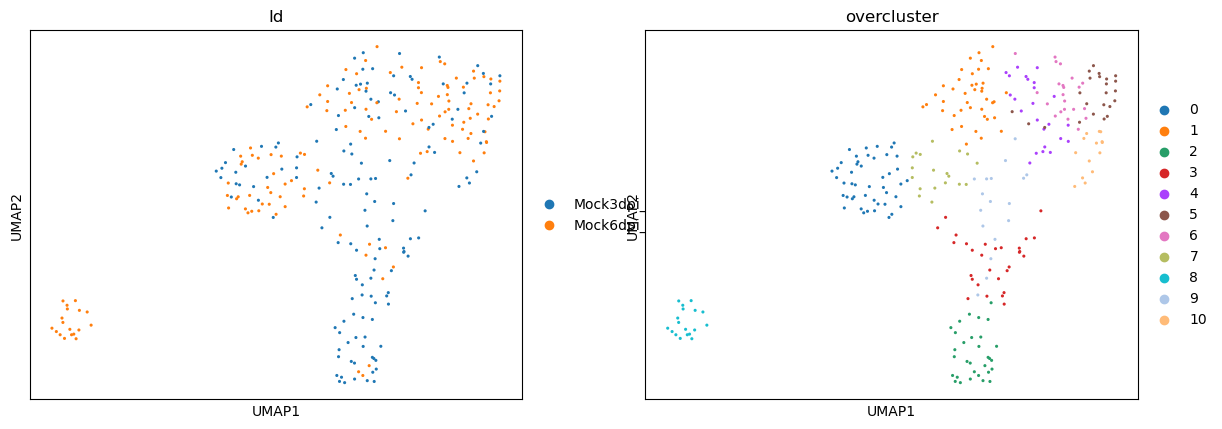

In [13]:
np.random.seed(1)
ri = np.random.permutation(list(range(adata_mock.shape[0])))

sc.pl.umap(adata_mock[ri,:], color = ['Id','overcluster'], vmin = .5, size = 20)

In [14]:
sc.tl.rank_genes_groups(adata_mock, groupby = 'overcluster')
marks = sc.get.rank_genes_groups_df(adata_mock, group = None)

In [15]:
adata_mock.obs

,Id,sample,overcluster
Mock_3dpi FINI\\TU016282CK_Slot1-01_1_4668.d-4,Mock3dpi_pg,Mock,2
Mock_3dpi FINI\\TU016284CK_Slot1-02_1_4670.d-4,Mock3dpi_pg,Mock,2
Mock_3dpi FINI\\TU016286CK_Slot1-03_1_4672.d-4,Mock3dpi_pg,Mock,2
Mock_3dpi FINI\\TU016288CK_Slot1-01_1_4674.d-4,Mock3dpi_pg,Mock,0
Mock_3dpi FINI\\TU016294CK_Slot1-04_1_4680.d-4,Mock3dpi_pg,Mock,9
...,...,...,...
mock_6/TU017810PAP_Slot1-01_1_6211.d-5,Mock6dpi_pg,Mock,8
mock_6/TU017811PAP_Slot1-02_1_6212.d-5,Mock6dpi_pg,Mock,7
mock_6/TU017813PAP_Slot1-03_1_6214.d-5,Mock6dpi_pg,Mock,4
mock_6/TU017814PAP_Slot1-04_1_6215.d-5,Mock6dpi_pg,Mock,0


In [16]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

In [17]:
#def ranking_evaluation_cluster(marks_cluster, size_rk):
#    selected_genes = marks_cluster['names'][:size_rk]
#    if marks_cluster.loc[marks_cluster['names'].isin(selected_genes), 'logfoldchanges'].isna().any():
#        raise ValueError("Error; NaN values found in the selected proteins")

#    ranking_id = marks_cluster['group'].unique()[0]
#    rankings_cluster = {f"{ranking_id}": {prot: i + 1 for i, prot in enumerate(selected_genes)}}
#    return rankings_cluster

In [18]:
def ranking_evaluation_cluster(marks_cluster):
    selected_genes = marks_cluster.loc[marks_cluster['logfoldchanges'] > 5, 'names']
    if marks_cluster.loc[marks_cluster['names'].isin(selected_genes), 'logfoldchanges'].isna().any():
        raise ValueError("Error: NaN values found in the selected proteins")

    ranking_id = marks_cluster['group'].unique()[0]
    rankings_cluster = {f"{ranking_id}": {prot: i + 1 for i, prot in enumerate(selected_genes)}}
    
    return rankings_cluster

In [19]:
#def ranking_evaluation(marks, size_rk):
    # do not allow NaN values
#    ranking = {}
#    for num in marks['group'].unique():
#        marks_cluster = marks[(marks.group == f"{num}") ].sort_values('logfoldchanges', ascending = False)
#        rankings_cluster = ranking_evaluation_cluster(marks_cluster, size_rk)
#        ranking.update(rankings_cluster)
#    return ranking

In [20]:
def ranking_evaluation(marks):
    # do not allow NaN values
    ranking = {}
    for num in marks['group'].unique():
        marks_cluster = marks[(marks.group == f"{num}") ].sort_values('logfoldchanges', ascending = False)
        rankings_cluster = ranking_evaluation_cluster(marks_cluster)
        ranking.update(rankings_cluster)
    return ranking

In [21]:
def common(ranking):
    all_genes = list(set.union(*[set(list(ranking[cluster].keys())) for cluster in list(ranking.keys())]))

    presence_matrix = pd.DataFrame(0, index=all_genes, columns=[f"Dataset {cluster}" for cluster in list(ranking.keys())])

    for cluster in list(ranking.keys()):
        presence_matrix.loc[list(ranking[cluster].keys()), f"Dataset {cluster}"] = 1

    compte = pd.DataFrame(0, index=all_genes, columns=[f"Seen in {i+1} clusters" for i in range(len(list(ranking.keys())))])
    sum_presencematrix = presence_matrix.sum(1)
    for gene in all_genes:
        presence_count = sum_presencematrix[gene] 
        compte.loc[gene, f"Seen in {presence_count} clusters"] = 1  


    column_sums = compte.sum(axis=0)


    plt.figure(figsize=(8, 6))
    sns.barplot(x=column_sums.index, y=column_sums.values, palette="viridis")

    plt.xlabel("Number of datasets where proteins seen")
    plt.ylabel("Number of proteins")
    plt.title("Number of proteins shared between datasets")


    plt.xticks(rotation=45)

    plt.show()

In [22]:
def custom_dendrogram(*args, **kwargs):
    dendro_data = sch.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for icoord, dcoord in zip(dendro_data['icoord'], dendro_data['dcoord']):
            x_coord = 0.5 * sum(icoord[1:3])  
            height = dcoord[1]  
            plt.plot(x_coord, height, 'ro') 
            plt.annotate(f"{height:.3g}", (x_coord, height), xytext=(0, -8),
                         textcoords='offset points', va='top', ha='center')  

    return dendro_data

In [23]:
def evolution_number_cluster(linkage_matrix):
    distances = linkage_matrix[:, 2]  
    max_distance = max(distances)
    cluster_counts = []

    for distance in distances:
        clusters = sch.fcluster(linkage_matrix, t=distance, criterion='distance')
        cluster_counts.append(len(np.unique(clusters)))

# print of the figure
    plt.figure(figsize=(8, 6))
    plt.plot(distances, cluster_counts, marker='o')
    plt.xlabel('Distance')
    plt.ylabel('Number of clusters')
    plt.title('Evolution of the number of cluster')
    plt.grid(True)
    plt.show()


In [24]:
def evolution_metacluster(linkage_matrix,list_cluster):

    distances = np.concatenate(([0], linkage_matrix[:, 2]))
    cluster_counts = []
    single_elements_counts = []

    n_elements = len(list_cluster)
    for distance in distances:
        clusters = np.concatenate(([0],sch.fcluster(linkage_matrix, t=distance, criterion='distance')))
        cluster_sizes = np.bincount(clusters)
    
        valid_clusters = np.sum(cluster_sizes >= 2)
        cluster_counts.append(valid_clusters)
    
        single_elements = np.sum(cluster_sizes == 1)
        single_elements_counts.append(single_elements)

    plt.figure(figsize=(8, 6))
    plt.plot(distances,cluster_counts, marker='o', label='MetaCluster')
    plt.xlabel('Distance')
    plt.ylabel('Number of MetaCluster')
    plt.title('Evolution of the number of MetaCluster')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(distances, single_elements_counts, marker='x', color='green', label='Number of clusters out of MetaCluster')
    plt.xlabel('Distance')
    plt.ylabel('Number of clusters out of MetaCluster')
    plt.title('Evolution of the Number of clusters out of MetaCluster depending of the distance')
    plt.grid(True)
    plt.legend()
    plt.show()

In [25]:
def ranking_dendrogramme(marks):
    ranking = ranking_evaluation(marks)
    common(ranking)

    all_prot = list(set.union(*[set(list(ranking[cluster].keys())) for cluster in list(ranking.keys())]))
    data = {}
    list_cluster = []
    for cluster_id, proteins in ranking.items():
        list_cluster.append(cluster_id)
        row = {prot: np.nan for prot in all_prot}
        for protein, rank in proteins.items():
            row[protein] = rank
        data[cluster_id] = row

    df_ranking = pd.DataFrame(data).T
    df_ranking.fillna(df_ranking.max().max()+1,inplace=True)
    dist_matrix = ssd.squareform(ssd.pdist(df_ranking, metric="correlation"))
    linkage_matrix = sch.linkage(dist_matrix, method="ward")

    evolution_number_cluster(linkage_matrix)
    evolution_metacluster(linkage_matrix,list_cluster)
    
    plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 4))
    dendro_data = custom_dendrogram(linkage_matrix)
    plt.title("Dendrogramm of the clusters")
    plt.xlabel("Clusters")
    plt.ylabel("Distance")
    plt.show()
    return all_prot

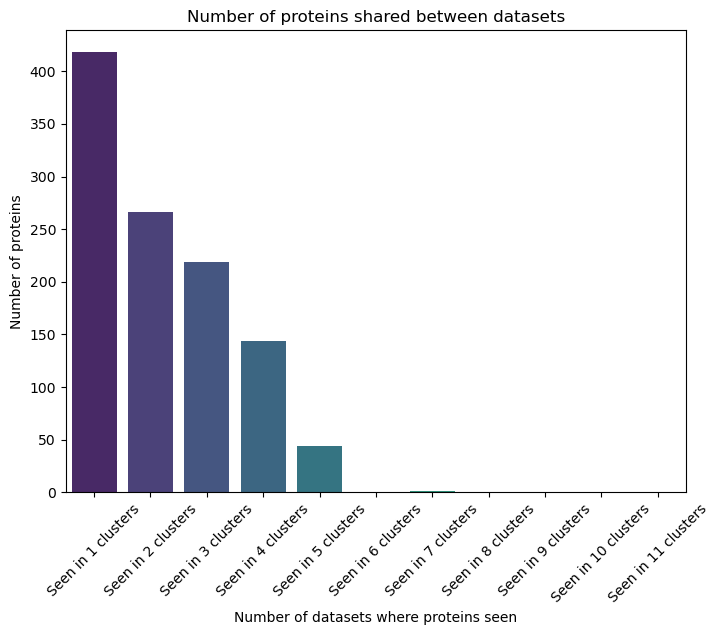

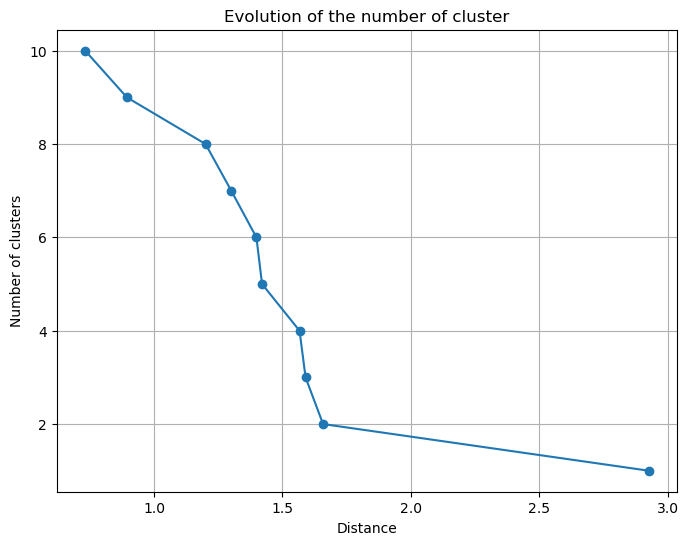

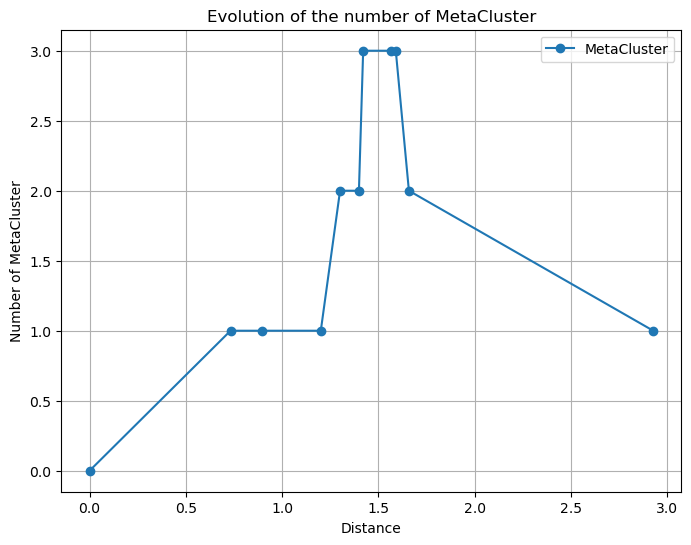

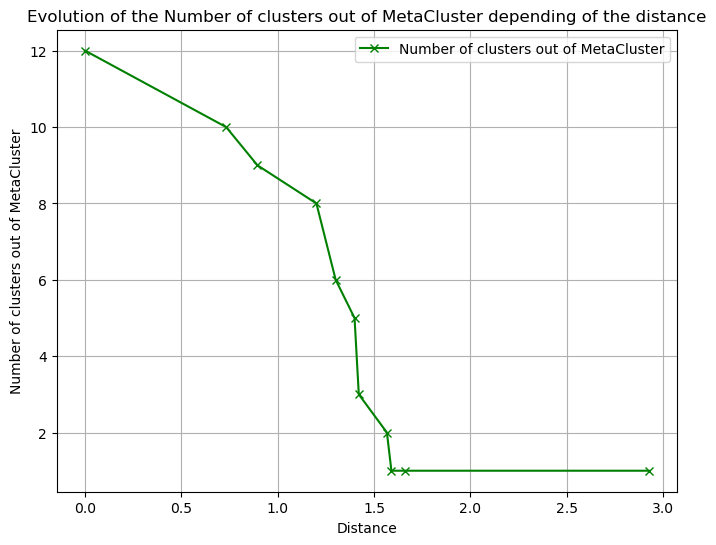

<Figure size 1000x500 with 0 Axes>

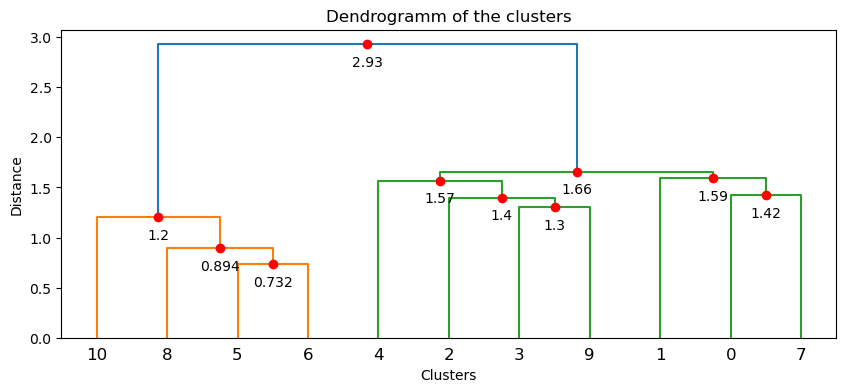

In [26]:
all_prot = ranking_dendrogramme(marks)

In [27]:
cluster_group1 = ['10','8','5','6','4']

In [28]:
cluster_group2 = [ '2', '3','9']# normalement il y a 4

In [29]:
cluster_group3 = ['1', '0', '7']

In [30]:
def metacluster_adding(cluster_group,adata,number):
    adata.obs.loc[adata.obs["overcluster"].astype(str).isin(cluster_group), "metacluster"] = str(number)

In [31]:
metacluster_adding(cluster_group1,adata_mock,1)

In [32]:
metacluster_adding(cluster_group2,adata_mock,2)

In [33]:
metacluster_adding(cluster_group3,adata_mock,3)

In [34]:
adata_mock.obs

,Id,sample,overcluster,metacluster
Mock_3dpi FINI\\TU016282CK_Slot1-01_1_4668.d-4,Mock3dpi_pg,Mock,2,2
Mock_3dpi FINI\\TU016284CK_Slot1-02_1_4670.d-4,Mock3dpi_pg,Mock,2,2
Mock_3dpi FINI\\TU016286CK_Slot1-03_1_4672.d-4,Mock3dpi_pg,Mock,2,2
Mock_3dpi FINI\\TU016288CK_Slot1-01_1_4674.d-4,Mock3dpi_pg,Mock,0,3
Mock_3dpi FINI\\TU016294CK_Slot1-04_1_4680.d-4,Mock3dpi_pg,Mock,9,2
...,...,...,...,...
mock_6/TU017810PAP_Slot1-01_1_6211.d-5,Mock6dpi_pg,Mock,8,1
mock_6/TU017811PAP_Slot1-02_1_6212.d-5,Mock6dpi_pg,Mock,7,3
mock_6/TU017813PAP_Slot1-03_1_6214.d-5,Mock6dpi_pg,Mock,4,1
mock_6/TU017814PAP_Slot1-04_1_6215.d-5,Mock6dpi_pg,Mock,0,3


In [35]:
#marks[(marks.group == '7') ].sort_values('logfoldchanges', ascending = False).head(60)

In [36]:
#marks[(marks.names == "RS19_HUMAN") ].sort_values('logfoldchanges', ascending = False).head(50)

In [37]:
def common_prot_clusters(marks,cluster_group,ranking):
    common_prot = list(set.intersection(*[set(list(ranking[cluster].keys())) for cluster in cluster_group]))
    return common_prot

In [38]:
def common_prot_clusters_mssv(marks, cluster_group, ranking):
    miss_value = 1
    all_proteins = set.union(*[set(ranking[cluster].keys()) for cluster in cluster_group])
    prot_count = {prot: sum(prot in ranking[cluster] for cluster in cluster_group) for prot in all_proteins}
    common_prot = [prot for prot, count in prot_count.items() if count >= len(cluster_group) - miss_value]
    return common_prot

In [39]:
def tab_sim_prot(marks,cluster_group):
    ranking = ranking_evaluation(marks)
    common_prot = common_prot_clusters(marks,cluster_group,ranking)
    print(common_prot)
    data = {}
    
    for cluster_id, proteins in ranking.items():
        if cluster_id in cluster_group:
            row = {prot: np.nan for prot in common_prot}
            for protein, rank in proteins.items():
                if protein in common_prot:
                    row[protein] = rank
            data[cluster_id] = row
    
    df_ranking = pd.DataFrame(data).T
    df_ranking.fillna(df_ranking.max().max()+1,inplace=True)
    return df_ranking

In [40]:
def tab_sim_prot_mssv(marks,cluster_group):
    ranking = ranking_evaluation(marks)
    common_prot = common_prot_clusters_mssv(marks,cluster_group,ranking)
    print(common_prot)
    data = {}
    
    for cluster_id, proteins in ranking.items():
        if cluster_id in cluster_group:
            row = {prot: np.nan for prot in common_prot}
            for protein, rank in proteins.items():
                if protein in common_prot:
                    row[protein] = rank
            data[cluster_id] = row
    
    df_ranking = pd.DataFrame(data).T
    df_ranking.fillna(df_ranking.max().max()+1,inplace=True)
    return df_ranking

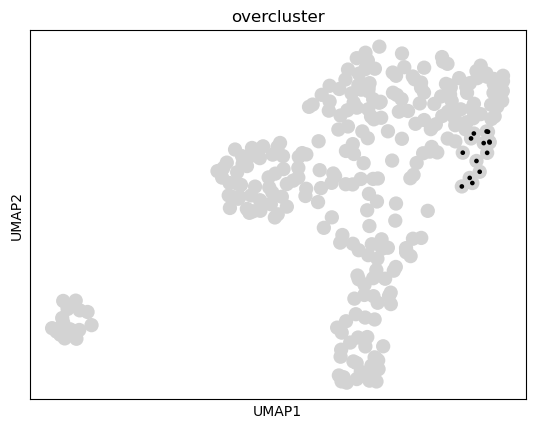

In [41]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
sc.pl.umap(adata_mock[adata_mock.obs.overcluster == '10'], color = 'overcluster',size =45, ax = ax, legend_loc = None, palette = 'k')

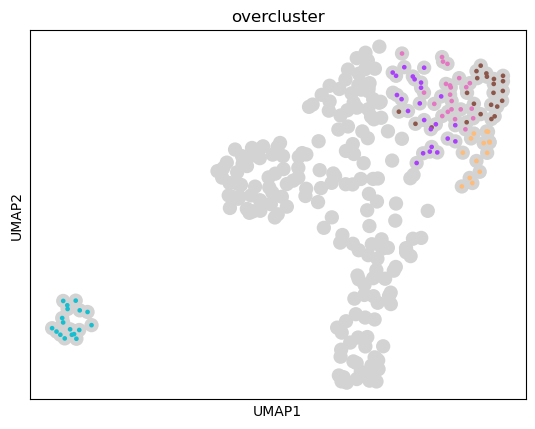

In [42]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
adata_clusters = adata_mock[adata_mock.obs['overcluster'].isin(cluster_group1)]

sc.pl.umap(adata_clusters, 
           color='overcluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  

plt.show()

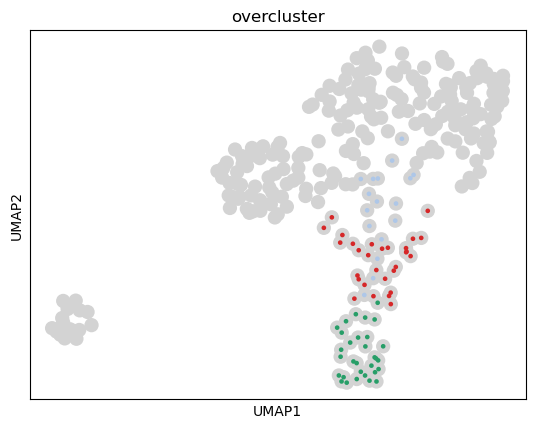

In [43]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
adata_clusters = adata_mock[adata_mock.obs['overcluster'].isin(cluster_group2)]

sc.pl.umap(adata_clusters, 
           color='overcluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  

plt.show()

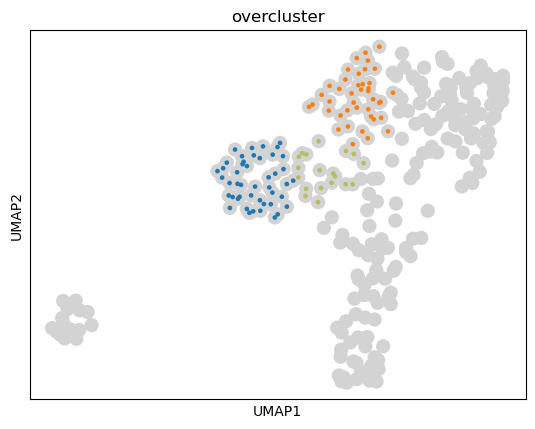

In [44]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
adata_clusters = adata_mock[adata_mock.obs['overcluster'].isin(cluster_group3)]

sc.pl.umap(adata_clusters, 
           color='overcluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  

plt.show()

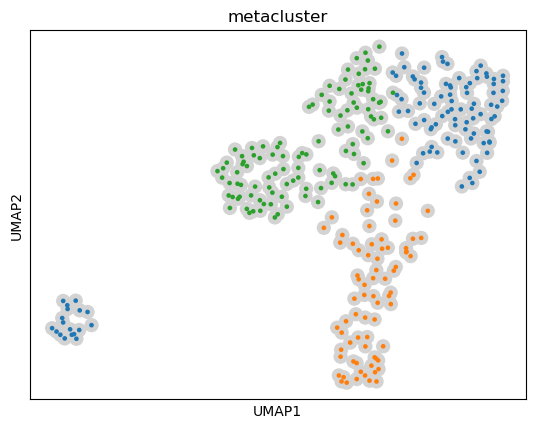

In [45]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
sc.pl.umap(adata_mock, 
           color='metacluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  
plt.show()

In [46]:
sc.tl.rank_genes_groups(adata_mock, groupby = 'metacluster')
marks_meta = sc.get.rank_genes_groups_df(adata_mock, group = None)

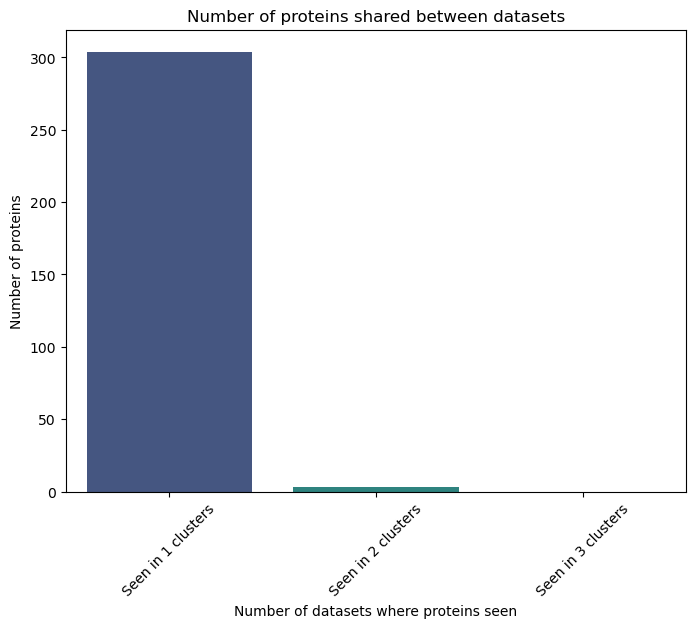

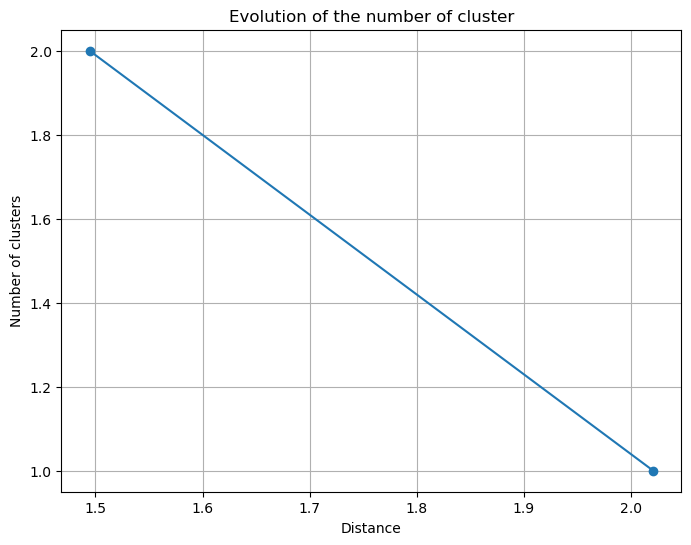

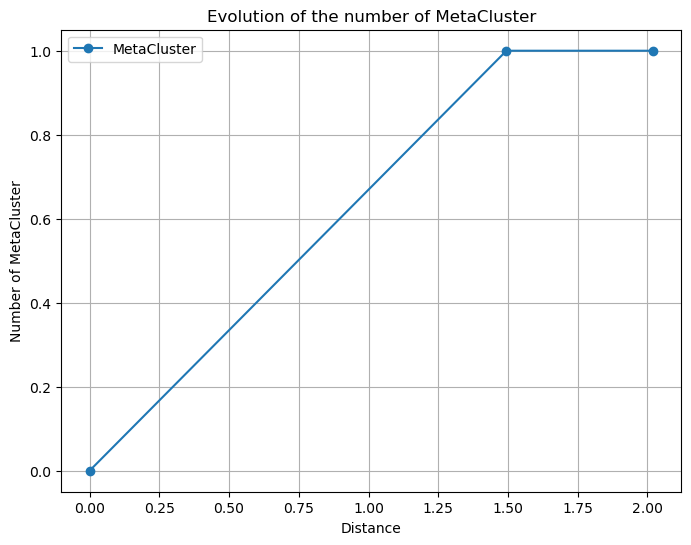

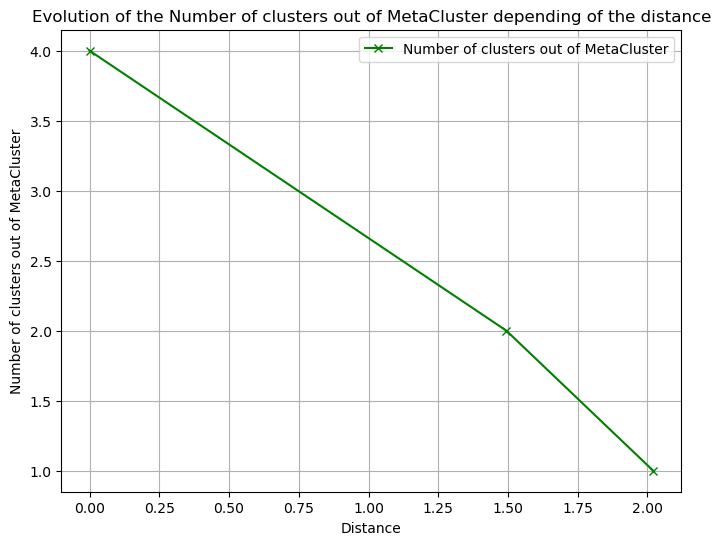

<Figure size 1000x500 with 0 Axes>

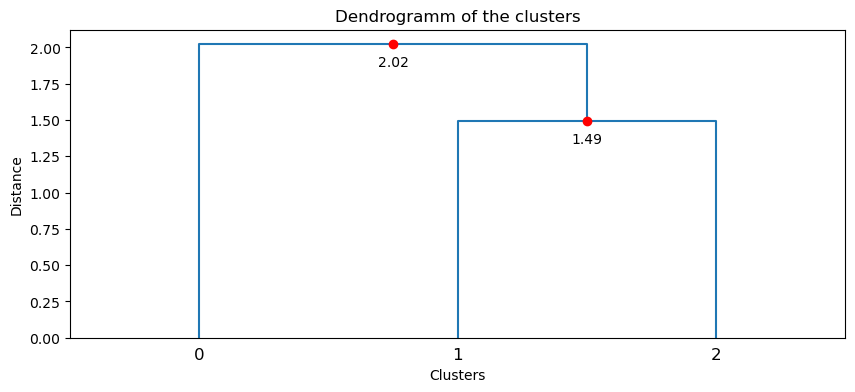

In [47]:
all_prot = ranking_dendrogramme(marks_meta)

# Comparaison btw metaclusters 

In [48]:
meta_1 = marks_meta[(marks_meta.group == '1') ].sort_values('logfoldchanges', ascending = False)

In [49]:
meta_2 = marks_meta[(marks_meta.group == '2') ].sort_values('logfoldchanges', ascending = False)

In [50]:
meta_3 = marks_meta[(marks_meta.group == '3') ].sort_values('logfoldchanges', ascending = False)

In [51]:
def filtre_metacluster(meta,num):
    filtered_meta = marks_meta[(marks_meta["group"] == str(num)) & (marks_meta["logfoldchanges"] >= 2) 
    &(marks_meta["pvals_adj"] <= 0.05) ].sort_values("logfoldchanges", ascending=False)

    return filtered_meta

In [52]:
filtered_meta1 = filtre_metacluster(meta_1,1)

In [53]:
filtered_meta2 = filtre_metacluster(meta_2,2)

In [54]:
filtered_meta3 = filtre_metacluster(meta_3,3)

In [55]:
adata1.var

,Genes
1433B_HUMAN,YWHAB
1433E_HUMAN,YWHAE
1433F_HUMAN,YWHAH
1433G_HUMAN,YWHAG
1433S_HUMAN,SFN
...,...
ZO2_HUMAN,TJP2
ZO3_HUMAN,TJP3
ZRAB2_HUMAN,ZRANB2
ZSWM8_HUMAN,ZSWIM8


In [56]:
prot_genes = dict(zip(adata1.var.index, adata1.var['Genes']))


In [57]:
filtered_meta1

,group,names,scores,logfoldchanges,pvals,pvals_adj
130,1,MK01_HUMAN,9.304501,14.810644,1.927725e-17,4.985678e-16
455,1,Trypsin,6.823482,14.743851,8.315523e-11,6.003712e-10
445,1,RHOC_HUMAN,6.872399,14.701242,6.007413e-11,4.404658e-10
132,1,SC24A_HUMAN,9.289271,14.687135,4.690922e-18,1.341888e-16
358,1,ABR_HUMAN,7.468791,14.647153,1.051283e-12,1.052956e-11
...,...,...,...,...,...,...
3113,1,TMX2_HUMAN,-2.460744,2.026520,1.457037e-02,2.830130e-02
3734,1,PPOX_HUMAN,-7.190902,2.019283,6.479641e-12,5.586102e-11
3467,1,NASP_HUMAN,-4.376958,2.001780,1.825259e-05,5.724402e-05
3294,1,RAVR1_HUMAN,-3.383073,2.000520,8.370470e-04,1.997907e-03


In [58]:
names_list1 = filtered_meta1["names"].tolist()

In [59]:
names_list1[:200]

['MK01_HUMAN',
 'Trypsin',
 'RHOC_HUMAN',
 'SC24A_HUMAN',
 'ABR_HUMAN',
 'EIF3M_HUMAN',
 'IQGA1_HUMAN',
 'SYK_HUMAN',
 'G6PD_HUMAN',
 'ANX11_HUMAN',
 'SYWC_HUMAN',
 'SPTN2_HUMAN',
 'RLA2_HUMAN',
 'ERF1_HUMAN',
 'LRC47_HUMAN',
 'TLN1_HUMAN',
 'TCPA_HUMAN',
 'SPT6H_HUMAN',
 'EIF3J_HUMAN',
 'SR140_HUMAN',
 'RCC2_HUMAN',
 'PALLD_HUMAN',
 'CSN1_HUMAN',
 'HDAC2_HUMAN',
 'ARP3_HUMAN',
 'PPCS_HUMAN',
 'SNX1_HUMAN',
 'SYTC_HUMAN',
 'GMPR2_HUMAN',
 'VILL_HUMAN',
 'LHPP_HUMAN',
 'PURA_HUMAN',
 'AAKG1_HUMAN',
 'EFHD2_HUMAN',
 'PAXX_HUMAN',
 'YTHD2_HUMAN',
 'HNRPD_HUMAN',
 'EIF3C_HUMANEIFCL_HUMAN',
 'PSPC1_HUMAN',
 'COPZ1_HUMAN',
 'NDUB5_HUMAN',
 'CAPZB_HUMAN',
 'CSRP1_HUMAN',
 'RM12_HUMAN',
 'SRP72_HUMAN',
 'EEA1_HUMAN',
 'TADBP_HUMAN',
 'TERA_HUMAN',
 'ACTY_HUMAN',
 'F262_HUMAN',
 'PSB9_HUMAN',
 'ARP5L_HUMAN',
 'ELAV1_HUMAN',
 'IF4A1_HUMAN',
 'PSA5_HUMAN',
 'ES8L2_HUMAN',
 'ESRP1_HUMAN',
 'NPL4_HUMAN',
 'ELOC_HUMAN',
 'TCPZ_HUMAN',
 'H2A2B_HUMAN',
 'TBB5_HUMAN',
 'PSB6_HUMAN',
 'LMAN1_HUMAN',
 'M

In [60]:
namesgene_list1 = [prot_genes.get(prot, None) for prot in names_list1]

In [61]:
len(namesgene_list1)

471

In [62]:
namesgene_list1_bt = namesgene_list1[:200]
for k in namesgene_list1_bt:
    print(k)

MAPK1
Trypsin
RHOC
SEC24A
ABR
EIF3M
IQGAP1
KARS
G6PD
ANXA11
WARS
SPTBN2
RPLP2
ETF1
LRRC47
TLN1
TCP1
SUPT6H
EIF3J
U2SURP
RCC2
PALLD
GPS1
HDAC2
ACTR3
PPCS
SNX1
TARS
GMPR2
VILL
LHPP
PURA
PRKAG1
EFHD2
PAXX
YTHDF2
HNRNPD
EIF3C;EIF3CL
PSPC1
COPZ1
NDUFB5
CAPZB
CSRP1
MRPL12
SRP72
EEA1
TARDBP
VCP
ACTR1B
PFKFB2
PSMB9
ARPC5L
ELAVL1
EIF4A1
PSMA5
EPS8L2
ESRP1
NPLOC4
ELOC
CCT6A
HIST2H2AB
TUBB
PSMB6
LMAN1
MYL1;MYL3
HDLBP
RPRD1B
DIS3
DDX3X
EIF3D
CCT7
ATP6V1B2
HMGN2
PA2G4
PEF1
ALDH1L1
SEPT7
SARS
DCTN2
DNM1L
CKMT1A
ARFIP1
FARSB
PSMD9
STIP1
ANXA7
EPRS
PSME3
GARS
CARM1
TUBB3
PPP2R2A
EIF2S3
ACYP1
PLPBP
OSBP
CCT3
EIF3F
CLINT1
PYGL
SF1
RPS28
PFKP
PBDC1
AP2A1
CAPZA2
CHMP3
DDX1
ARPC1A
PAPSS1
PRKAA1
DYNC1LI1
PACSIN2
KHSRP
UNC45A
NAE1
ARFGEF1
DYNC1LI2
CPSF6
RNMT
CSDE1
PDE12
HSP90AA1
HUWE1
USP10
AP3B1
NSUN2
CELF1
RPL29
AHSA1
OSGEP
PGM2L1
XRCC6
UGDH
ARHGEF12
RTRAF
SEPT9
EIF5
DNAJA1
ACSL3
MAPK13
EIF3A
EIF2S1
RPL11
APOL2
RUVBL1
SRSF1
GAK
SEC23A
KPNB1
MSN
EIF4G2
TSG101
USP9X
SNX5
PSMD8
PDCD4
POLR2E
ALMS1
USP7
DCTN1
U

In [63]:
namesgene_list1_bt = namesgene_list1[200:400]
for k in namesgene_list1_bt:
    print(k)

SERPINB1
SYNCRIP
PSMB5
RARS
PSMC6
HNRNPA2B1
DUSP23
STK24
MYCBP
TUBB6
ERAP1
FUBP3
EML4
FARSA
HNRNPAB
COPS4
AP3D1
AFDN
ADD1
TPM3
NCKAP1
ARHGAP18
XRN2
RPA1
EIF3K
CAPRIN1
SAMHD1
HNRNPA3
CTBP1
FLII
MAP1A
SPR
ITGA2
AP2M1
RPL18A
PFKM
ADD3
PURB
PSMD13
KATNAL2
DDX19A
PTPN11
CHMP2A
MYL6
NAP1L4
PSMD3
HMGB3
PAK2
CACYBP
GAPVD1
BUB3
RPL19
PPP3CA
CUL5
BROX
EPPK1
CPNE3
WDR54
NDUFA9
VPS35
FXR1
DNAJC7
CARS
RPL10A
ANK3
C8orf82
ACLY
RPS14
ERP44
PABPN1
MESD
PSMD12
ATP6V1D
SRSF3
DRG1
UPF1
RPL35A
HNRNPH3
LLGL2
UQCR10
TRAP1
DHX9
PPT1
FAM120A
PTGR1
CSNK1A1
DDX17
SERPINB2
SCFD1
LRRC57
SSBP1
DAZAP1
SFPQ
SURF4
DNAJB11
RPL17
KIF5B
NAGK
DNAH5
VPS13C
PPM1G
SLC25A12
MAGOH
SRC
RPS3
CTSS
RPL30
MRPL38
RPS6
TOMM40
SRSF4
SLC27A2
SPTAN1
CTTN
ABHD10
BANF1
COPG2
DUOX1
GCN1
UFC1
PLEC
LARS
SH3GL1
LMNA
DIAPH1
SCARB2
PIGK
MYO1B
ATP5PF
DDX5
RPL15
GFM1
PICALM
FKBP9
LRRFIP1
TMEM126A
RPL7
CBR1
ACOT9
FAHD1
PSMC2
TMC5
EFHC1
PRKAR2A
MRPL46
NCLN
EIF5B
GSTO1
RPL27A
P4HB
PITRM1
TROVE2
PDIA6
AKR1B10
Catalase
RNPS1
TXNDC17
HSPB11
YWHAG
B4GA

In [64]:
filtered_meta2

,group,names,scores,logfoldchanges,pvals,pvals_adj
4969,2,CTNB1_HUMAN,4.390534,8.629271,1.869585e-05,0.000042
5286,2,WDFY1_HUMAN,2.595528,8.174396,1.017604e-02,0.017277
4943,2,MYCBP_HUMAN,4.515548,7.847356,1.556935e-05,0.000035
5330,2,CF298_HUMAN,2.387817,7.528455,1.839792e-02,0.030048
5217,2,TMOD3_HUMAN,3.028976,7.293374,2.737932e-03,0.004937
5241,2,RS11_HUMAN,2.917030,6.011486,3.933591e-03,0.006980
5181,2,RL4_HUMAN,3.255368,5.969232,1.303885e-03,0.002424
4831,2,RL6_HUMAN,5.223431,5.753690,4.204358e-07,0.000001
5285,2,CBR1_HUMAN,2.599798,5.370823,1.059297e-02,0.017929
4961,2,MGN_HUMAN,4.417725,5.342391,1.567315e-05,0.000036


In [65]:
names_list2 = filtered_meta2["names"].tolist()

In [66]:
namesgene_list2 = [prot_genes.get(prot, None) for prot in names_list2]

In [67]:
len(namesgene_list2)

35

In [68]:
for k in namesgene_list2:
    print(k)

CTNNB1
WDFY1
MYCBP
CFAP298
TMOD3
RPS11
RPL4
RPL6
CBR1
MAGOH
RPN1
HNRNPDL
YBX1
POLR2E
RPS3
DARS
THRAP3
ARGLU1
GPX1
DYNC1H1
CAST
HNRNPUL1
RPL13
SLC25A11
RPL26
HSPA1B
IGF2BP2
ALOX12B
RPL7
ATP6V1E1
EEF1E1
HAL
SNRNP70
CCAR2
CPA4


In [69]:
filtered_meta3

,group,names,scores,logfoldchanges,pvals,pvals_adj
10228,3,SH3L2_HUMAN,-4.379127,7.361514,0.000018,0.000059
9681,3,HNRPK_HUMAN,-3.393377,7.123582,0.000859,0.001903
9982,3,NOLC1_HUMAN,-3.905085,6.412210,0.000130,0.000353
10400,3,PPIH_HUMAN,-4.735395,6.392579,0.000004,0.000015
7616,3,KATL2_HUMAN,2.967896,6.195199,0.003294,0.006512
...,...,...,...,...,...,...
10372,3,BST2_HUMAN,-4.661079,2.089335,0.000005,0.000019
10356,3,NFU1_HUMAN,-4.629878,2.072738,0.000006,0.000023
10387,3,H1X_HUMAN,-4.697353,2.064629,0.000004,0.000016
9582,3,1433G_HUMAN,-3.225771,2.044736,0.001415,0.002969


In [70]:
names_list3 = filtered_meta3["names"].tolist()

In [71]:
namesgene_list3 = [prot_genes.get(prot, None) for prot in names_list3]

In [72]:
for k in namesgene_list3:
    print(k)

SH3BGRL2
HNRNPK
NOLC1
PPIH
KATNAL2
KDM1A
NCBP1
LYPLAL1
IMPACT
ANXA1
RBBP4
CDKN2AIP
CKB
MUC16
PHPT1
CBX1
Glutathione
NME9
OPA1
FBXL8
ALKBH5
PTGES3
KDELR1
DTHD1
NNT
SLC15A2
STIM1
NCK2
TMED2
IFIT5
VAC14
OPLAH
RAB13
SERPINB2
HDHD2
FNTA
Ubiquitin-40S
CTPS2
DCDC2B
EIF2S2
CHID1
ODF3B
SIRT2
TACSTD2
EFHC1
ENO2
TTC39C
C11orf54
DDX18
TMC5
ERMP1
CDC5L
PNPT1
SMC2
PPP1R13L
RAB10
DHX38
STAM2
IGF2BP3
ASNS
DHRS9
ITGA2
PNN
SMARCC2
XPNPEP1
SAFB
CNOT2
ATP2B4
PCNA
HNRNPLL
PRPS2
TP53BP1
NUP93
TPM2
GSTT1
TIMM13
TMEM106B
PMPCA
PLXNB2
TSGA10
ODAD3
RCN1
IPO4
RWDD1
TRMT1L
ANKMY2
MGLL
CAPS
RPP30
APPL1
SNW1
GBE1
CFAP57
CPSF1
HIP1R
ALDH5A1
DPP9
RNPS1
COBLL1
ERAP1
DNAI2
NEU1
PPIF
MYO1C
GALK1
DDB2
CYP2A13
ATP5PF
BST2
NFU1
H1FX
YWHAG
IL18


In [115]:
#groupe1= Secretory
#group2 = Ciliated cells
#group3 = Basals & superbasals

In [ ]:
# not possible to differentiate the groups based on the logfoldchange but with specific 
# markers the groups can be identified based on the caracteristic of the cells

In [147]:
marks[(marks.names == "FILA_HUMAN") ].sort_values('logfoldchanges', ascending = False).head(50)

,group,names,scores,logfoldchanges,pvals,pvals_adj
10489,2,FILA_HUMAN,-2.708489,0.494815,0.009977,0.017975
14728,3,FILA_HUMAN,-2.569378,0.442790,0.014116,0.040719
37727,9,FILA_HUMAN,-4.685517,0.414475,0.000054,0.001778
41414,10,FILA_HUMAN,-3.547403,0.343971,0.001156,0.015813
26006,6,FILA_HUMAN,-1.757505,0.334739,0.088836,0.200865
29065,7,FILA_HUMAN,-1.509140,0.331609,0.144924,0.386464
21781,5,FILA_HUMAN,-0.875909,0.258769,0.388426,0.639362
31393,8,FILA_HUMAN,0.322307,-0.202881,0.750206,1.000000
38,0,FILA_HUMAN,4.006784,NaN,0.000158,0.000287
4325,1,FILA_HUMAN,2.738189,NaN,0.008802,0.031930


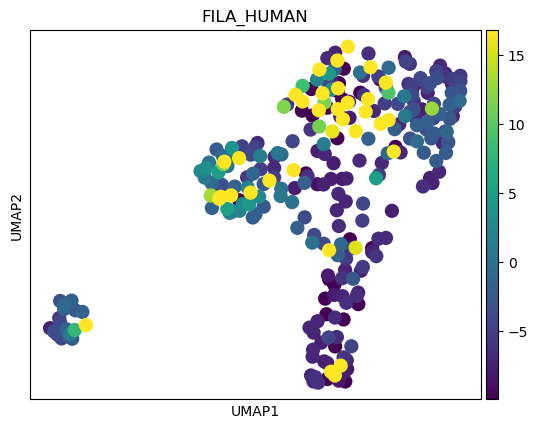

In [146]:
sc.pl.umap(
    adata_mock,
    color=['FILA_HUMAN'])

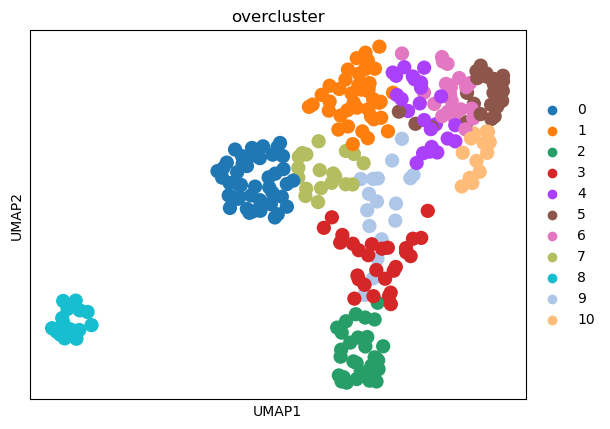

In [57]:
sc.pl.umap(
    adata_mock,
    color=['overcluster']
)

In [ ]:
Prot_markers = {
    "Secretory":["SC23A_HUMAN","SAR1A_HUMAN","COPB_HUMAN","TS101_HUMAN","AP2A1_HUMAN","AQP5_HUMAN"],
    "Ciliated cells":["TBA1A_HUMAN","DYH5_HUMAN","KIF3A_HUMAN"],
    "Basales":["K2C5_HUMAN","K1C14_HUMAN","FILA_HUMAN"] # if mix btw secretory and basale = superbasale (FILA + secretory)
}